**Task VI - Quantum Representation Learning:**



*   Load the MNIST dataset

*   Write a function which takes an image and prepares a quantum state. This function should have trainable parameters which we want to learn in order to have good quantum representations

*   Create a circuit with which takes two images and embeds both as quantum states with the function you wrote before. Afterwards the circuit should perform a SWAP test between the two states. In the end the measurement should give the fidelity of the quantum states.

*   Train the circuit parameters with a contrastive loss: For two MNIST images in the same class the fidelity should be maximized, while for images of different classes the fidelity should be minimized.



Some important notes regarding the contrastive loss: classically, it is based on the cosine distance. In our case, we aim for the fidelity - I modify the **InfoNCE loss**, specifically. Given an image pair (**query**,**positive**) or (**query**,**negative**):



*   we extract two representations from the given pair, **h1** and **h2**.
*   These are embedded into the quantum circuit showed.


*   In the end, a **SWAP test** is made between the two quantum states.
*   Since we are running on a simulator, we know the fidelity reduces to the squared inner product **|<Ψ|φ>|^2** .


*   Each qubit i measured from the SWAP test gives **P(0) = 1/2 + (1/2)*|< i | j >|^2** . So we estimate |< i | j >| as:






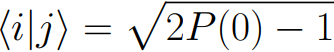

### Important: in my tests, I noticed that this leads to **numerical instabilities!** Even adding a small epsilon to the formula before taking the square root does not solve it. So, instead, the final similarity is the sum of the squares of each inner product, instead of the sum of the smaller inner products.

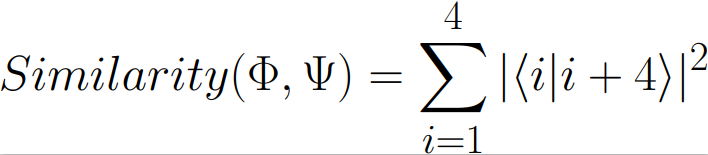

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting .sample_data/MNIST/raw/train-images-idx3-ubyte.gz to .sample_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting .sample_data/MNIST/raw/train-labels-idx1-ubyte.gz to .sample_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting .sample_data/MNIST/raw/t10k-images-idx3-ubyte.gz to .sample_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting .sample_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to .sample_data/MNIST/raw



Seed set to 42
Seed set to 42


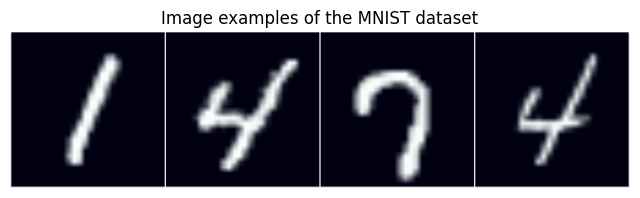

In [5]:
import os
import urllib.request
from urllib.error import HTTPError

import matplotlib
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from IPython.display import set_matplotlib_formats
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from torchvision import transforms
from torchvision.datasets import  MNIST

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Lambda(lambda x: x.repeat(3,1,1)),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    ]
)
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3,1,1)),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    ]
)


# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = MNIST(root=".sample_data", train=True, transform=train_transform, download=True)
val_dataset = MNIST(root=".sample_data", train=True, transform=test_transform, download=True)
pl.seed_everything(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [55000, 5000])
pl.seed_everything(42)
_, val_set = torch.utils.data.random_split(val_dataset, [55000, 5000])

# Loading the test set
test_set = MNIST(root=".sample_data", train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

# Visualize some examples
NUM_IMAGES = 4
MNIST_images = torch.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(MNIST_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Image examples of the MNIST dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

In [7]:
def H_layer(n_qubits, n_ancillas):
    for idx in range(n_ancillas, n_qubits): # 0th qubits reserved for ancilla purposes
        qml.Hadamard(idx)

def RY_layer(w, n_ancillas):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w, start=n_ancillas): # 1st qubit is ancilla, used for SWAP test here.
        qml.RY(element, wires=idx)


def entangling_layer(nqubits, n_ancillas):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(n_ancillas, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(n_ancillas + 1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

### Let's modify the original InfoNCE loss for... quantum.

In [51]:
import torch
import torch.nn.functional as F
from torch import nn



class InfoNCE(nn.Module):
    """
    Calculates the InfoNCE loss for self-supervised learning, but uses the fidelity between quantum states instead of cosine.
    This contrastive loss enforces the embeddings of similar (positive) samples to be close
        and those of different (negative) samples to be distant.
    A query embedding is compared with one positive key and with one or more negative keys.
    References:
        https://arxiv.org/abs/1807.03748v2
        https://arxiv.org/abs/2010.05113
    Args:
        temperature: Logits are divided by temperature before calculating the cross entropy.
        reduction: Reduction method applied to the output.
            Value must be one of ['none', 'sum', 'mean'].
            See torch.nn.functional.cross_entropy for more details about each option.
        negative_mode: Determines how the (optional) negative_keys are handled.
            Value must be one of ['paired', 'unpaired'].
            If 'paired', then each query sample is paired with a number of negative keys.
            Comparable to a triplet loss, but with multiple negatives per sample.
            If 'unpaired', then the set of negative keys are all unrelated to any positive key.
    Input shape:
        query: (N, D) Tensor with query samples (e.g. embeddings of the input).
        positive_key: (N, D) Tensor with positive samples (e.g. embeddings of augmented input).
        negative_keys (optional): Tensor with negative samples (e.g. embeddings of other inputs)
            If negative_mode = 'paired', then negative_keys is a (N, M, D) Tensor.
            If negative_mode = 'unpaired', then negative_keys is a (M, D) Tensor.
            If None, then the negative keys for a sample are the positive keys for the other samples.
    Returns:
         Value of the InfoNCE Loss.
     Examples:
        >>> loss = InfoNCE()
        >>> batch_size, num_negative, embedding_size = 32, 48, 128
        >>> query = torch.randn(batch_size, embedding_size)
        >>> positive_key = torch.randn(batch_size, embedding_size)
        >>> negative_keys = torch.randn(num_negative, embedding_size)
        >>> output = loss(query, positive_key, negative_keys)
    """

    def __init__(self, n_qubits, n_ancillas, q_depth, q_params, temperature=0.1, epsilon = 1e-4, reduction='mean', negative_mode='unpaired'):
        super().__init__()
        self.temperature = temperature
        self.reduction = reduction
        self.negative_mode = negative_mode
        
        self.n_qubits = n_qubits
        self.n_ancillas = n_ancillas
        self.q_depth = q_depth
        self.q_params = q_params
        self.epsilon = epsilon

    def forward(self, query, positive_key, negative_keys=None, get_similarities = False):
        return info_nce(query, positive_key, negative_keys,
                        temperature=self.temperature,
                        epsilon = self.epsilon,
                        reduction=self.reduction,
                        negative_mode=self.negative_mode,
                        q_params = self.q_params,
                        q_depth = self.q_depth,
                        n_qubits = self.n_qubits,
                        n_ancillas = self.n_ancillas,
                        get_similarities = get_similarities)


def info_nce(query, positive_key, negative_keys=None, temperature=0.1, epsilon = 1e-4, reduction='mean', negative_mode='unpaired',
             q_params=None, q_depth=None, n_qubits=None, n_ancillas=None, get_similarities = False):
    
    assert q_params is not None
    assert q_depth is not None
    assert n_qubits is not None
    assert n_ancillas is not None
    
    # Check input dimensionality.
    if query.dim() != 2:
        raise ValueError('<query> must have 2 dimensions.')
    if positive_key.dim() != 2:
        raise ValueError('<positive_key> must have 2 dimensions.')
    if negative_keys is not None:
        if negative_mode == 'unpaired' and negative_keys.dim() != 2:
            raise ValueError("<negative_keys> must have 2 dimensions if <negative_mode> == 'unpaired'.")
        if negative_mode == 'paired' and negative_keys.dim() != 3:
            raise ValueError("<negative_keys> must have 3 dimensions if <negative_mode> == 'paired'.")

    # Check matching number of samples.
    if len(query) != len(positive_key):
        raise ValueError('<query> and <positive_key> must must have the same number of samples.')
    if negative_keys is not None:
        if negative_mode == 'paired' and len(query) != len(negative_keys):
            raise ValueError("If negative_mode == 'paired', then <negative_keys> must have the same number of samples as <query>.")

    # Embedding vectors should have same number of components.
    if query.shape[-1] != positive_key.shape[-1]:
        raise ValueError('Vectors of <query> and <positive_key> should have the same number of components.')
    if negative_keys is not None:
        if query.shape[-1] != negative_keys.shape[-1]:
            raise ValueError('Vectors of <query> and <negative_keys> should have the same number of components.')

    # Normalize to unit vectors
    # query, positive_key, negative_keys = normalize(query, positive_key, negative_keys)
    q_in_query = torch.tanh(query) * np.pi / 2.0
    q_in_pos = torch.tanh(positive_key) * np.pi / 2.0

    
    if negative_keys is not None:
        # Explicit negative keys
        q_in_neg = torch.tanh(negative_keys) * np.pi / 2.0
        # Cosine between positive pairs
        # should return: Tensor([[0.81], [0.009], [-1.2], ...]]) 
        # positive_logit = torch.sum(query * positive_key, dim=1, keepdim=True)
        positive_logit = torch.Tensor(0, 1)#query.shape[0])
        for h1, h2 in zip(q_in_query, q_in_pos): # CHECK THAT h1 and h2 have single dim.

            q_pair = torch.cat((h1, h2), axis=0) # hidden representations concatenated into single vector.

            similarity = embed_image(q_input_features=q_pair, q_weights_flat=q_params, q_depth=q_depth, n_qubits=n_qubits, n_ancillas=n_ancillas, train=True)

            similarity = (2*similarity - 1 + epsilon)#**0.5
            similarity = torch.sum(similarity) # = sum(<i|j>) = <q_in_1 | q_in_2 >; i,j=1...n_qubits
            similarity = similarity**2

            positive_logit = torch.cat((positive_logit, similarity.unsqueeze(0).unsqueeze(0)), 0)

            
        if negative_mode == 'unpaired':
            # Cosine between all query-negative combinations
            # should return: cosine similarity matrix
            # or: fidelity matrix.

            negative_logits = torch.Tensor(0, query.shape[0])
            for h_query in query:
                row_aux = torch.Tensor(0)
                for h_neg in negative_keys:

                    q_pair = torch.cat((h_query, h_neg), axis=0) # hidden representations concatenated into single vector.

                    similarity = embed_image(q_input_features=q_pair, q_weights_flat=q_params, q_depth=q_depth, n_qubits=n_qubits, n_ancillas=n_ancillas, train=True)
                    similarity = (2*similarity - 1 + epsilon)#**0.5
                    similarity = torch.sum(similarity) # = sum(<i|j>) = <q_in_1 | q_in_2 >; i,j=1...n_qubits
                    similarity = similarity**2

                    row_aux = torch.cat((row_aux, similarity.unsqueeze(0)), 0) # row_aux = [] -> [1.0] -> [1.0, -3.2] - > ...

                negative_logits = torch.cat((negative_logits, row_aux.unsqueeze(0)), 0)


        elif negative_mode == 'paired':
            # should return: cosine similarity matrix
            # or: fidelity matrix.

            negative_logits = torch.Tensor(0, query.shape[0])
            for idx, h_query in enumerate(query):
                row_aux = torch.Tensor(0)
                for h_neg in negative_keys[idx]:

                    q_pair = torch.cat((h_query, h_neg), axis=1) # hidden representations concatenated into single vector.

                    similarity = embed_image(q_input_features=q_pair, q_weights_flat=self.q_params, q_depth=q_depth, n_qubits=n_qubits, n_ancillas=n_ancillas, train=True)
                    similarity = (2*similarity - 1 + epsilon)#**0.5
                    similarity = torch.sum(similarity) # = sum(<i|j>) = <q_in_1 | q_in_2 >; i,j=1...n_qubits
                    similarity = similarity**2

                    row_aux = torch.cat((row_aux, similarity.unsqueeze(0)), 0) # row_aux = [] -> [1.0] -> [1.0, -3.2] - > ...

                negative_logits = torch.cat((negative_logits, row_aux.unsqueeze(0)), 0)

        # First index in last dimension are the positive samples
        logits = torch.cat([positive_logit, negative_logits], dim=1)
        labels = torch.zeros(len(logits), dtype=torch.long, device=query.device)
    else:
        # Negative keys are implicitly off-diagonal positive keys.

        # Cosine between all combinations
        # should return: cosine similarity matrix
        # or: fidelity matrix.
        # logits = query @ transpose(positive_key)

        # print("SHAPES QUERY: {}\nSHAPES POSITIVE KEY: {}".format(query.shape, positive_key.shape))
        logits = torch.Tensor(0, query.shape[0])
        for h_query in query:
            row_aux = torch.Tensor(0)
            for h_pos in positive_key:
                q_pair = torch.cat((h_query, h_pos), axis=0) # hidden representations concatenated into single vector.

                similarity = embed_image(q_input_features=q_pair, q_weights_flat=q_params, q_depth=q_depth, n_qubits=n_qubits, n_ancillas=n_ancillas, train=True)
                similarity = (2*similarity - 1 + epsilon)#**0.5
                similarity = torch.sum(similarity) # = sum(<i|j>) = <q_in_1 | q_in_2 >; i,j=1...n_qubits
                similarity = similarity**2

                row_aux = torch.cat((row_aux, similarity.unsqueeze(0)), 0) # row_aux = [] -> [1.0] -> [1.0, -3.2] - > ...
                
            logits = torch.cat((logits, row_aux.unsqueeze(0)), 0)
        if get_similarities == True:
            return logits
            
        # Positive keys are the entries on the diagonal
        labels = torch.arange(len(query), device=query.device)
        
    return F.cross_entropy(logits / temperature, labels, reduction=reduction)

In [9]:
import pennylane as qml

dev = qml.device("default.qubit", wires=12)


@qml.qnode(dev, interface="torch")
def embed_image(q_input_features, q_weights_flat, q_depth, n_qubits, n_ancillas, train=False):
    """
    The variational quantum circuit. It takes the image hidden representation
    and prepares a quantum state using trainable parameters.

    Given 2 images, they go through a classical resnet, which in the end gives a classical feature vector of dim = (n_qubits = 4 in this example).
        - Image 1 is then encoded in a Parametrized Quantum Circuit (PQC), giving the state |Ψ>.
        - Image 2 is then encoded in the same Parametrized Quantum Circuit (PQC), giving the state |φ>.
    We have then proceed to define a PQC consisting of 3*n_qubits, that is:
        - n_qubits as ancilliary ones.
        - n qubits for the first image.
        - n qubits for the second image.
    In the end, through a CSAWP test, we estimate the inner product <Ψ|φ>. More specifically, we estimate |<Ψ|φ>|^2, which is
    the fidelity measure for pure states.

    If train == True, then it performs a SWAP test, returning the fidelity in the end. Else, it return the measurements in the Z basis.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits - 4)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits, n_ancillas)

    # Embed features in the quantum node
    RY_layer(q_input_features, n_ancillas)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits, n_ancillas)
        RY_layer(q_weights[k], n_ancillas)

    if train == False:
        # Expectation values in the Z basis
        exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_ancillas, n_qubits)]
        return tuple(exp_vals)

    else: # performs SWAP test & returns fidelity estimate.
        
        for idx in range(n_ancillas):
            qml.Hadamard(idx)
            qml.CSWAP(wires = [idx, idx + n_ancillas, idx + 2*n_ancillas])
            qml.Hadamard(idx)

        # exp = qml.probs(wires=[0]) #qml.expval(qml.PauliZ(0)) # expected value of ancilla qubit (0-th qubit)

        # P(0) = 1/2 + (1/2)*|<psi|phi>|^2

        # s = 2*exp - 1 # s is the estimate of the inner product |<psi|phi>|^2, also the fidelity
        
        exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_ancillas)]

        return tuple(exp_vals) #qml.expval(qml.PauliZ(0)) #expval

## Finally, our model

In [94]:
import torch
import numpy as np
from torch import nn

class QuantumFidelityNet(nn.Module): # Hybrid NN trained on contrastive learning using fidelity as measure of similarity.
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self, classical_net, n_qubits, q_depth = 1, q_delta=0.001, negative_mode='unpaired'):
        """
        Definition of the *dressed* layout.

        Attention: n_qubits includes the ancillas !!!
        """

        super().__init__()
        self.n_qubits = n_qubits
        self.n_ancillas = int(n_qubits / 3)
        self.q_depth = q_depth
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * (n_qubits - self.n_ancillas) ))

        self.classical_net = classical_net
        self.loss = InfoNCE(self.n_qubits, self.n_ancillas, 
                            self.q_depth, self.q_params,
                            epsilon = 0,
                            negative_mode='unpaired')

        for param in self.classical_net.parameters():
            param.requires_grad = False

        self.classical_net.fc = nn.Linear(512, (self.n_qubits -  self.n_ancillas)// 2)

        # showscase our PQC
        print(qml.draw(embed_image)(q_input_features=torch.rand(8), q_weights_flat=self.q_params, q_depth=self.q_depth, n_qubits=self.n_qubits, n_ancillas=self.n_ancillas, train=True))

    def forward(self, query, positives = None, negatives = None, train=False):

        """
        Given 2 images, they go through a classical resnet, which in the end gives a classical feature vector of dim = (n_qubits = 4 in this example).
            - Image 1 is then encoded in a Parametrized Quantum Circuit (PQC), giving the state |Ψ>.
            - Image 2 is then encoded in a Parametrized Quantum Circuit (PQC), giving the state |φ>.
        We have then proceed to define a PQC consisting of 2*n_qubits + 1, that is:
            - 1 ancilliary qubit.
            - n qubits for the first image.
            - n qubits for the second image.
        In the end, through a CSAWP test, we estimate the inner product <Ψ|φ>. More specifically, we estimate |<Ψ|φ>|^2, which is
        the fidelity measure for pure states.
        """

        repr_1 = self.classical_net(query) # [B, n_qubits] : (batch_size, n_qubits)
        if negatives is not None and train == True:
            repr_2 = self.classical_net(positives) 
            repr_3 = self.classical_net(negatives) 
            return self.loss(repr_1, repr_2, repr_3)
        elif negatives is not None and positives is not None and train == True:
            repr_2 = self.classical_net(positives) 
            return self.loss(repr_1, repr_2)
        elif query is not None and positives is not None and train == False:
            repr_2 = self.classical_net(positives)
            return self.loss(repr_1, repr_2, get_similarities = True)

        return embed_image(q_input_features=repr_1, q_weights_flat=self.q_params, q_depth=self.q_depth, n_qubits=self.n_qubits, n_ancillas=self.n_ancillas, train=train)

# Let's also define a dataset of triplets for MNIST:

In [11]:
def generate_pairs(dataset, max_size = None):
    """
    Creates a collection of positive and negative image pairs from the supplied
    array of images.

    A positive pair contains two images of the same digit. A negative pair contains
    two images representing different digits.
    """

    x_triplets = []

    for i in range(len(dataset)):

        label = dataset[i][1]

        complete = [False, False]
        aux = [dataset[i][0]]
        for j in range(len(dataset)):
            if dataset[j][1] == label and complete[1] == False:
                aux.append(dataset[j][0])
                complete[1] = True
            elif dataset[j][1] != label and complete[0] == False:
                aux.append(dataset[j][0])
                complete[0] = True

            if complete[0] == True and complete[1] == True:
                break

        x_triplets.append(torch.stack(aux))

        
        if max_size != None and i >= max_size:
            break


    return torch.stack(x_triplets)

In [12]:
train_triplets_tensor = generate_pairs(train_dataset, max_size = 128)
val_triplets_tensor = generate_pairs(val_dataset, max_size = 32)
test_triplets_tensor = generate_pairs(test_set, max_size = 32)

In [13]:
from torch.utils.data import Dataset, DataLoader

class MNISTTripletsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, triplets_tensor):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.triplets_tensor = triplets_tensor

    def __len__(self):
        return len(self.triplets_tensor)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = {'query': self.triplets_tensor[idx, 0], 'positive': self.triplets_tensor[idx, 1], 'negative': self.triplets_tensor[idx, 2]}

        return sample

In [14]:
train_triplets_dataset = MNISTTripletsDataset(train_triplets_tensor)
val_triplets_dataset = MNISTTripletsDataset(val_triplets_tensor)
test_triplets_dataset = MNISTTripletsDataset(test_triplets_tensor)

### Let's choose the classical net that will reduce the dimensionality of our images

In [15]:
import torchvision

classical_net = torchvision.models.resnet18(pretrained=True)

/home/jogi/anaconda3/envs/quantum/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jogi/anaconda3/envs/quantum/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/jogi/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

## Let's create our QuantumFidelityNet and see how our PQC looks like:

In [169]:
qfn = QuantumFidelityNet(classical_net, n_qubits = 12, q_depth=1, q_delta=0.001)

 0: ──H───────────────────────────────────╭●─────H────────────────────────────┤  <Z>
 1: ──────────────────────────────────────│──────H─╭●─────H───────────────────┤  <Z>
 2: ──────────────────────────────────────│────────│──────H─╭●─────H──────────┤  <Z>
 3: ──────────────────────────────────────│────────│────────│──────H─╭●─────H─┤  <Z>
 4: ──H──RY(0.76)─╭●──RY(0.00)────────────├SWAP────│────────│────────│────────┤     
 5: ──H──RY(0.44)─╰X─╭●─────────RY(0.00)──│────────├SWAP────│────────│────────┤     
 6: ──H──RY(0.92)─╭●─╰X─────────RY(0.00)──│────────│────────├SWAP────│────────┤     
 7: ──H──RY(0.71)─╰X─╭●─────────RY(-0.00)─│────────│────────│────────├SWAP────┤     
 8: ──H──RY(0.15)─╭●─╰X─────────RY(0.00)──╰SWAP────│────────│────────│────────┤     
 9: ──H──RY(0.79)─╰X─╭●─────────RY(0.00)───────────╰SWAP────│────────│────────┤     
10: ──H──RY(0.97)─╭●─╰X─────────RY(-0.00)───────────────────╰SWAP────│────────┤     
11: ──H──RY(0.39)─╰X──RY(0.00)───────────────────────────────────

In [170]:
def train_one_epoch():
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for batch_idx in range(len(train_triplets_dataset)):
        # Every data instance is an input + label pair
        # inputs, labels = data

        if (batch_idx + 1) * 16 >= len(train_triplets_dataset):
            data_idx = [i for i in range(batch_idx*16, len(train_triplets_dataset) - 1)]
        else:
            data_idx = [i for i in range(batch_idx*16, (batch_idx + 1)*16)]

        if len(data_idx) == 0:
            break


        query = train_triplets_dataset[data_idx]["query"]
        pos = train_triplets_dataset[data_idx]["positive"]
        neg = train_triplets_dataset[data_idx]["negative"]

        
        # Zero the gradients for every batch!
        optimizer.zero_grad()

        loss = qfn(query, pos, neg, train=True)
        loss.backward()
        
        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        last_loss = running_loss / 1000 # loss per batch
        print('  batch {} loss: {}'.format(batch_idx + 1, last_loss))
        running_loss = 0.

    return last_loss

In [171]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(qfn.parameters(), lr=0.001, momentum=0.9)

## Let's check the training convergence

In [172]:
for epoch in range(5):
    print("=================== EPOCH {} ====================".format(epoch + 1))
    train_one_epoch()

=================== EPOCH 1 ====================
  batch 1 loss: 0.06936117550009722
  batch 2 loss: 0.0002733819036666039
  batch 3 loss: 0.0020217629398514994
  batch 4 loss: 0.003587976129693084
  batch 5 loss: 0.003509684279171427
  batch 6 loss: 0.0029073710421338543
  batch 7 loss: 0.0006762974936306605
  batch 8 loss: 2.807645594911545e-09
=================== EPOCH 2 ====================
  batch 1 loss: 2.4003506925217226e-10
  batch 2 loss: 0.0010181489180995284
  batch 3 loss: 3.886939514357327e-13
  batch 4 loss: 7.309395470065087e-08
  batch 5 loss: 0.0016261620611663509
  batch 6 loss: 5.129995258380334e-06
  batch 7 loss: 7.56628820934926e-07
  batch 8 loss: 0.0009406436845658677
=================== EPOCH 3 ====================
  batch 1 loss: 5.906038531586888e-12
  batch 2 loss: 0.004354658467465923
  batch 3 loss: 9.514932937126301e-12
  batch 4 loss: 7.003406155340695e-11
  batch 5 loss: 0.001433972783237133
  batch 6 loss: 0.0016384750734163046
  batch 7 loss: 0.00029